In [1]:
%%writefile load_imgs.py
import cv2
import numpy as np
def load_img(direct,file,size=100):
    pic = cv2.imread(direct+file)
    pic = cv2.resize(pic,(size,size))
    
    if "cat" in file:
        label = 0
    else:
        label = 1
    
    return [pic,label]


Overwriting load_imgs.py


In [2]:
import time
start_time = time.time()
import numpy as np
import pandas as pd
from multiprocessing import Pool
from load_imgs import load_img

from tqdm.notebook import tqdm


import cv2
import PIL
from os import listdir
import random

%matplotlib inline
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.metrics import accuracy_score, classification_report




randomSeed = 36
np.random.seed(randomSeed)

## <u><b> Part 1 </b></u>

### Loading the data

We will use the multiprocessing library to make loading our images much faster in parallel

In [3]:
picSize = 100
img_to_load = [(r"data/dogs-vs-cats/train/",i,picSize) for i in listdir(r"data/dogs-vs-cats/train/")]

#Will use all cpu cores available
p = Pool(processes=None)

out = p.starmap(load_img,img_to_load)


In [4]:
data = np.array([out[i][0] for i in range(len(out))])
target = [out[i][1] for i in range(len(out))]
out=None

## <u><b> Part 2 </b></u>

### Train/Test split

In [5]:
X_train, X_test, y_train, y_test  = train_test_split(data.reshape(len(data),picSize*picSize*3), target, test_size=0.25, random_state=randomSeed)


## <u><b> Part 3 </b></u>

### Building our Pipeline cutom meathods

We will add all our transformations into a single pipeline so we can apply all our transformations easly


In [6]:
class erode_img(BaseEstimator, TransformerMixin):
    def __init__(self,matrix=None, iterations=0,picSize=100):
        self.matrix = matrix
        self.picSize = picSize
        self.iterations=iterations
    def fit(self, Data, y=None):
        return self
    def transform(self,Data,y=None):
        newData = []
        if self.iterations > 0:
            for i in range(len(Data)):
                if Data[i].shape != (self.picSize,self.picSize) and Data[i].shape != (self.picSize,self.picSize,3):
                    newData.append(cv2.erode(Data[i].reshape(self.picSize,self.picSize,3),self.matrix,iterations=self.iterations))
                else:
                    newData.append(cv2.erode(Data[i],self.matrix,iterations=self.iterations))
            return newData
        return Data
    def inverse_transform(self,Data,y=None):
        return Data

In [7]:
class dilate_img(BaseEstimator, TransformerMixin):
    def __init__(self,matrix=None, iterations=0, picSize=100):
        self.matrix = matrix
        self.iterations=iterations
        self.picSize = picSize
    def fit(self, Data, y=None):
        return self
    def transform(self,Data, y=None):
        newData = []
        if self.iterations > 0:
            for i in range(len(Data)):
                if Data[i].shape != (self.picSize,self.picSize) and Data[i].shape != (self.picSize,self.picSize,3):
                    newData.append(cv2.dilate(Data[i].reshape(self.picSize,self.picSize,3),self.matrix,iterations=self.iterations))
                else:
                    newData.append(cv2.dilate(Data[i],self.matrix,iterations=self.iterations))
            return newData
        return Data
    def inverse_transform(self,Data,y=None):
        return Data

In [8]:
class grayScale(BaseEstimator, TransformerMixin):
    def __init__(self,picSize=100):
        self.picSize = picSize
    def fit(self, Data, y=None):
        return self
    def transform(self,Data, y=None):
        newData = []
        for i in range(len(Data)):
            if Data[i].shape != (self.picSize,self.picSize,3):
                newData.append(cv2.cvtColor(Data[i].reshape(self.picSize,self.picSize,3), cv2.COLOR_BGR2GRAY))
            else:
                newData.append(cv2.cvtColor(Data[i], cv2.COLOR_BGR2GRAY))
        return newData
    def inverse_transform(self,Data,y=None):
        return Data

In [9]:
class reShape(BaseEstimator, TransformerMixin):
    def __init__(self,picSize=100):
        self.picSize = picSize
    def fit(self, Data, y=None):
        return self

    def transform(self,Data, y=None):
        processed_data = np.array(Data)
        processed_data = np.array([a.flatten() for a in processed_data])
        return processed_data

    def inverse_transform(self, Data,y=None):
        newData = Data.copy()
        newData = newData.reshape(len(newData),self.picSize,self.picSize)
        return newData

In [10]:
class to_df(BaseEstimator, TransformerMixin):
    
    def fit(self, Data, y=None):
        return self

    def transform(self,Data, y=None):
        df = pd.DataFrame(Data)
        return df
    def inverse_transform(self, Data,y=None):
       
        newData = Data.to_numpy()
        return newData

## <u><b> Part 4 </b></u>

### Visualizing our pipeline transformations

We will go over what our pipeline does behind the scenes

The steps are as follows:

1. Transforming the images by bluring, dilating, eroding and gray scaling the images
2. Transforming the 2d image matrices to a 1d arrays in a data frame
3. Reducing the images dimension with pca and finding the best dimension
4. Moving our data into a Dataframe

 Step 1: Transforming the data

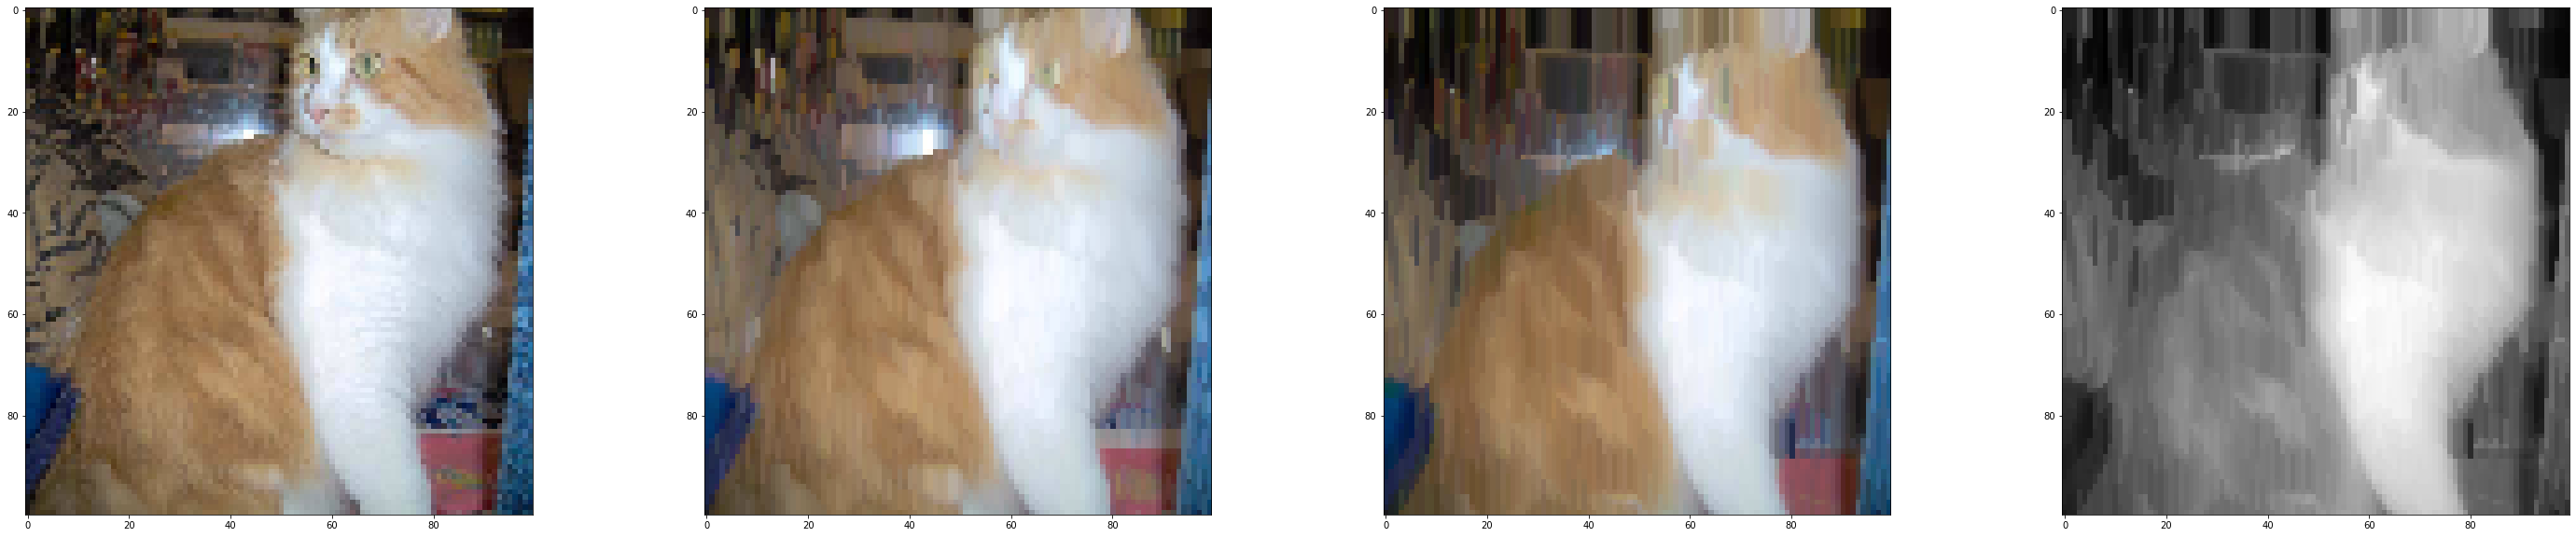

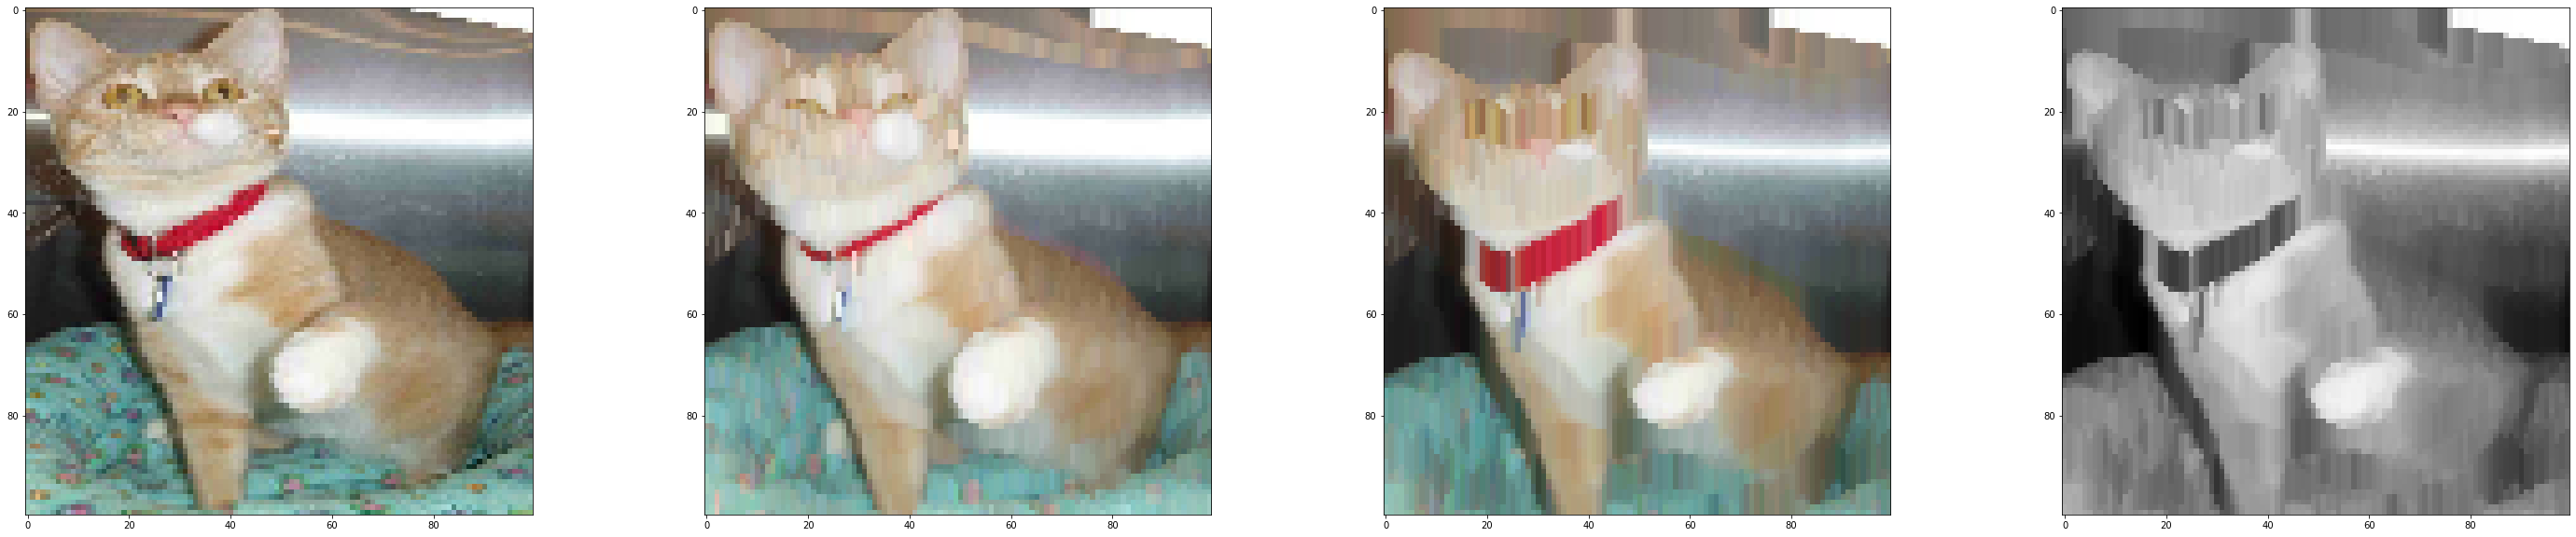

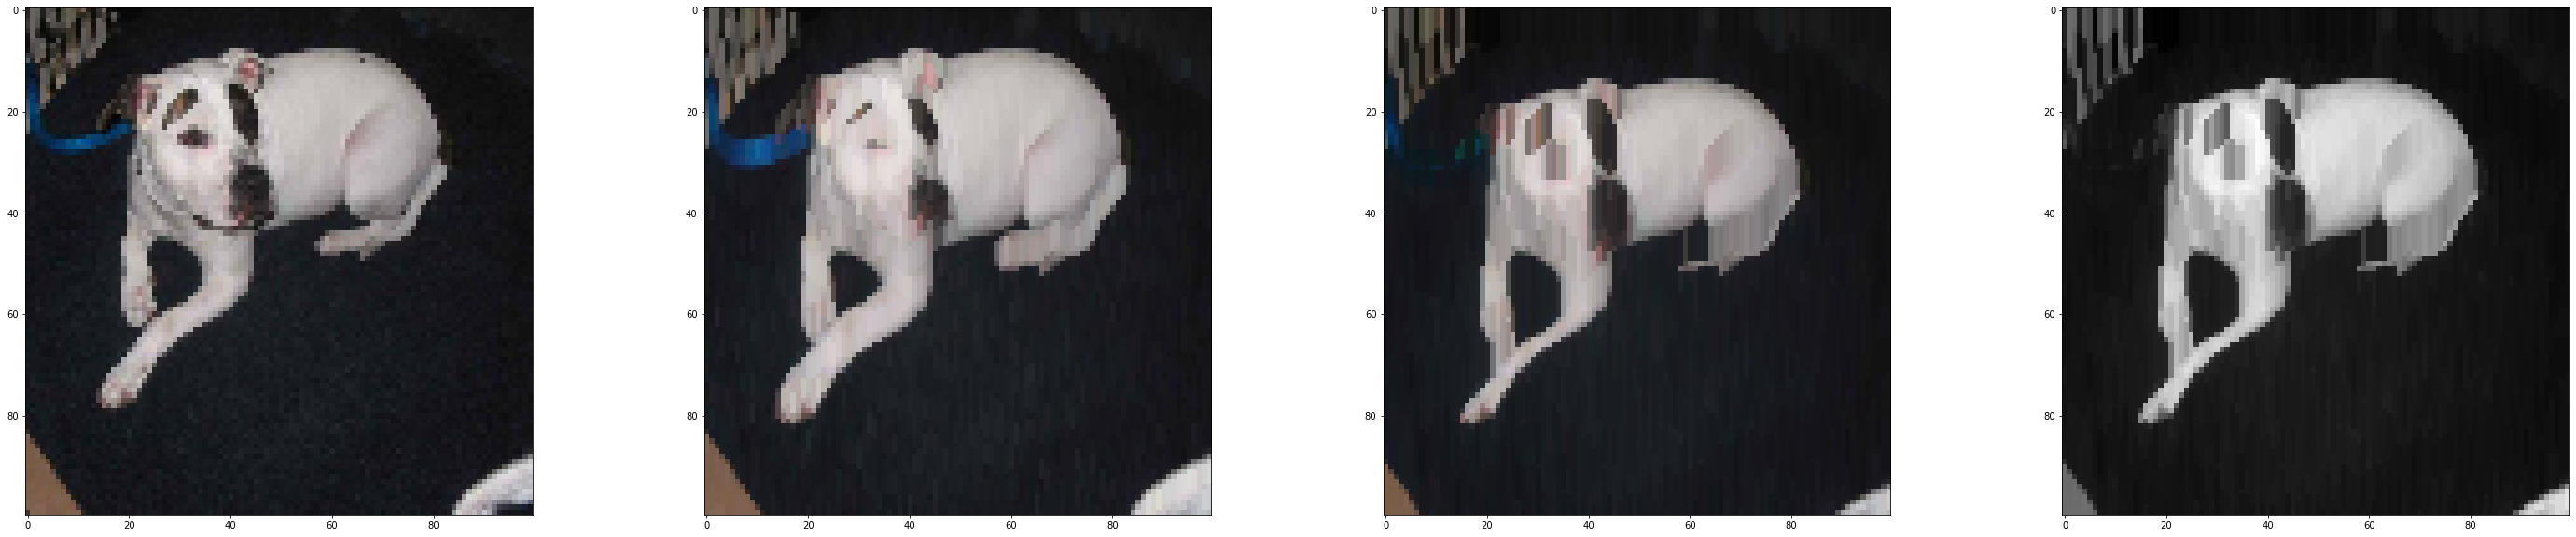

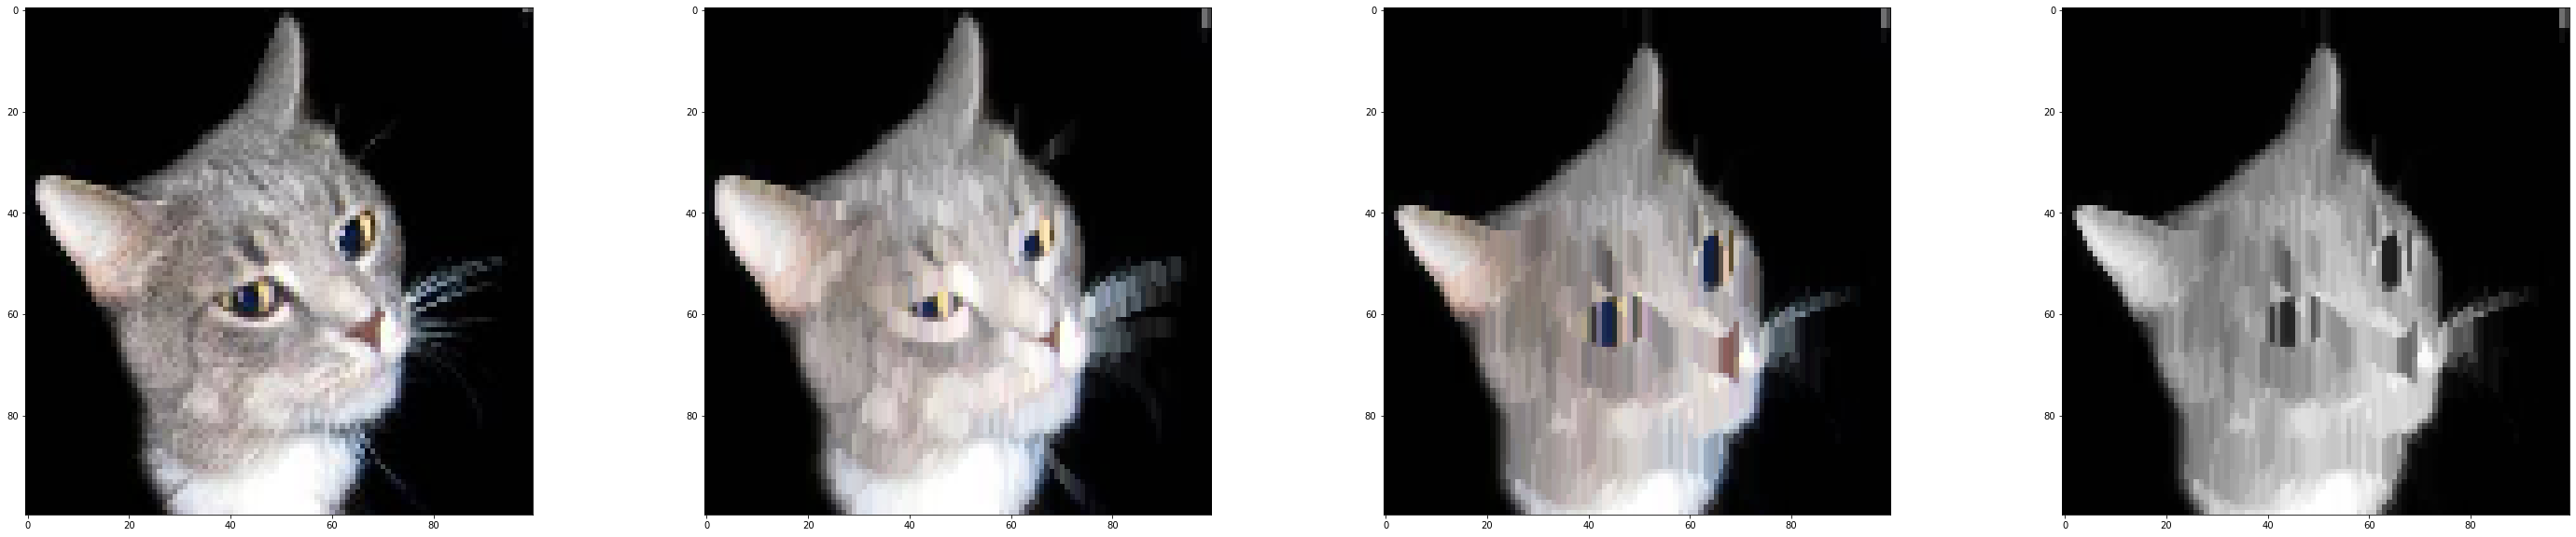

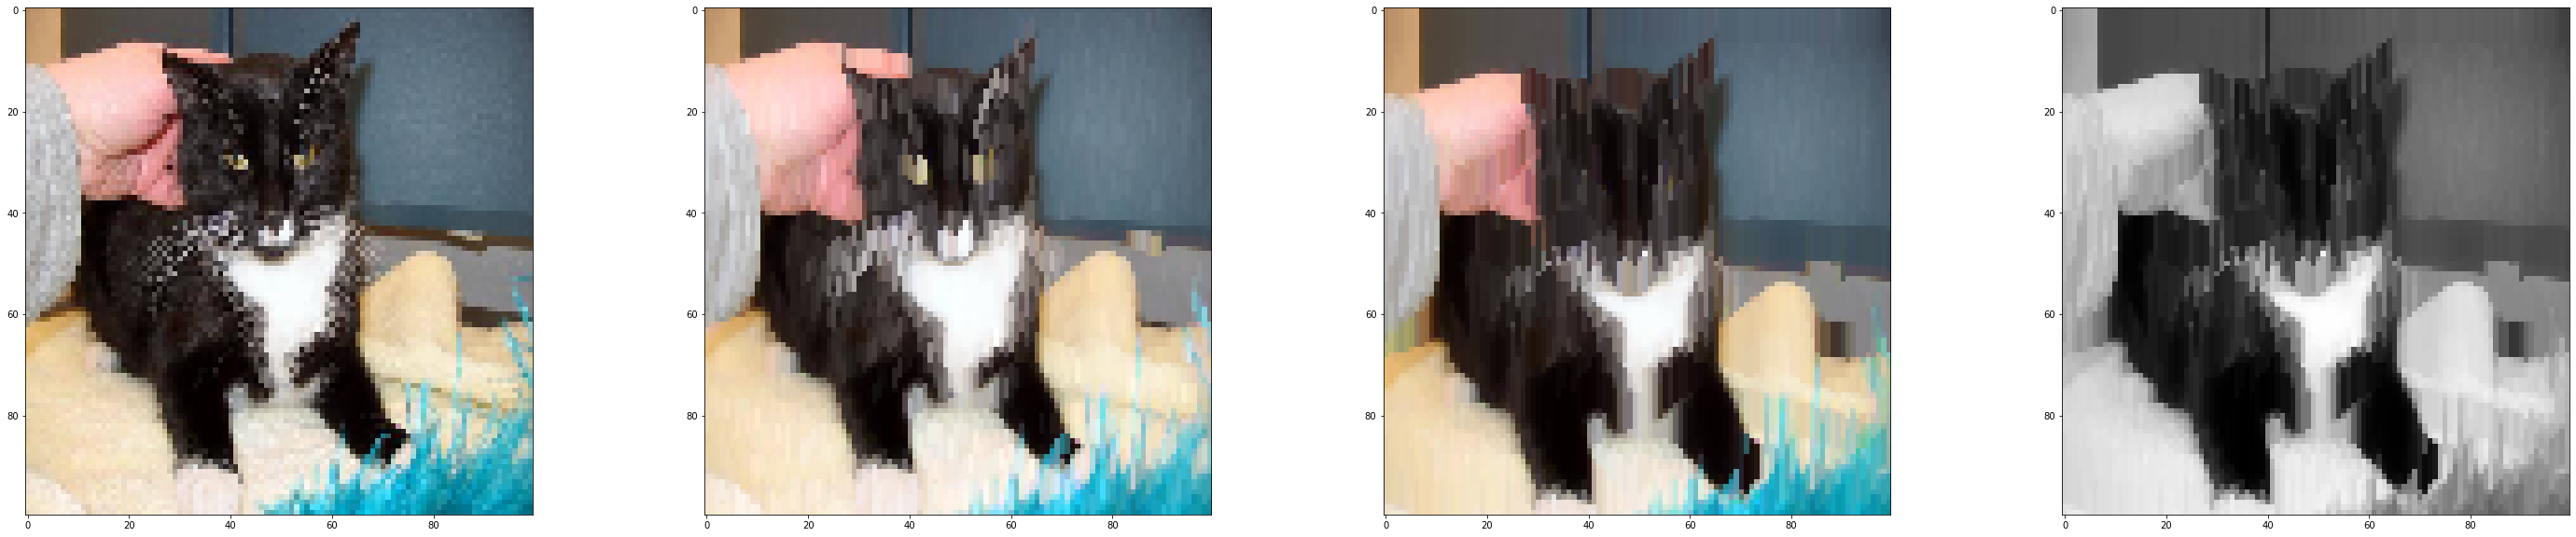

In [11]:
for i in range(5):
   
    dilated = cv2.dilate(data[i],(1,1),iterations=3)
    eroded = cv2.erode(dilated,(3,3),iterations=6)
    grayScaled = cv2.cvtColor(eroded, cv2.COLOR_BGR2GRAY)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.set_size_inches(50,10)
    ax1.imshow(cv2.cvtColor(data[i],cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(dilated,cv2.COLOR_BGR2RGB))
    ax3.imshow(cv2.cvtColor(eroded,cv2.COLOR_BGR2RGB))
    ax4.imshow(grayScaled,cmap="gray")

Here we have our Image transformation pipeline

In [12]:
img_preprocessing = Pipeline([
    ("dilate",dilate_img(picSize=picSize)),
    ("erode",erode_img(picSize=picSize)),
    ("grayScale",grayScale(picSize=picSize)),
    ("reshape",reShape(picSize=picSize)),
    ("toDF", to_df())
])

Step 2: Reducing dimensions

We will first try to reduce our dimensions of our original train set without any transformations

In [13]:
X_train_new = img_preprocessing.fit_transform(X_train)
X_test_new = img_preprocessing.transform(X_test)
X_train_new.head(5)

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,253,253,239,249,231,65,104,65,41,67,...,48,21,38,35,29,27,254,251,255,255
1,168,169,170,171,171,171,170,170,172,172,...,195,199,202,203,207,215,218,217,202,179
2,255,255,255,255,255,255,255,255,255,255,...,238,243,245,246,243,244,246,246,245,246
3,31,35,5,12,30,36,41,36,71,73,...,70,85,85,78,34,35,34,33,32,38
4,228,235,225,242,246,250,249,232,120,113,...,209,208,208,208,207,205,205,207,205,204


In [14]:
#X_train_new = np.array([cv2.cvtColor(i.reshape(picSize,picSize,3), cv2.COLOR_BGR2GRAY) for i in X_train])
#X_test_new = np.array([cv2.cvtColor(i.reshape(picSize,picSize,3), cv2.COLOR_BGR2GRAY) for i in X_test])
#X_train_new = X_train_new.reshape((len(X_train_new),picSize*picSize))
#X_test_new = X_test_new.reshape((len(X_test_new),picSize*picSize))
#X_train_new.shape

In [15]:
pca = PCA(random_state=randomSeed)
pca.fit(X_train_new)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)


Feature variance ratio without any transformations

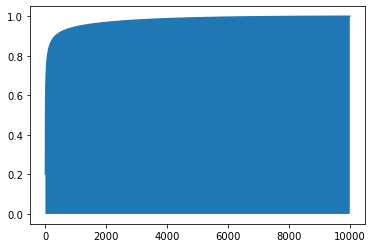

In [16]:
fig, ax = plt.subplots()
ax.plot(range(1,exp_var_cumul.shape[0] + 1),exp_var_cumul)
ax.fill_between(range(1,exp_var_cumul.shape[0] + 1),exp_var_cumul,0)

In [17]:
maxFeatures = len(exp_var_cumul[exp_var_cumul<0.95])
exp_var_cumul[maxFeatures], maxFeatures

(0.9500202983670518, 1126)

step 3: Finding optimal paramaters for transformations

In [18]:
 grid = {
    'dilate__matrix':[(5,5)],
    'dilate__iterations':[6,9],
    'erode__matrix':[(5,5)],
    'erode__iterations':[6,9]
}
params = ParameterGrid(grid)

In [19]:
def get_best_transformations(params,threshold=0.95,verbose=True):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
    print("Testing",len(params),"combinations of paramaters")
    start = time.time()
    last_update = time.time()
    param_combo = {
        'dilate__matrix':[],
        'dilate__iterations':[],
        'erode__matrix':[],
        'erode__iterations':[]
    }
    best_params = {
        'dilate__matrix':None,
        'dilate__iterations':None,
        'erode__matrix':None,
        'erode__iterations':None
    }
    trainAcc = []
    testAcc = []
    dims = []
    times = []
    best_dim =  picSize**2
    with tqdm(total=len(params)) as pbar:
        for param in params:

            img_preprocessing.set_params(**param)
            X_train_new = img_preprocessing.fit_transform(X_train)
            X_test_new = img_preprocessing.transform(X_test)

            pca = PCA(n_components=threshold,random_state=randomSeed)
            X_train_new = pca.fit_transform(X_train_new)
            X_test_new = pca.transform(X_test_new)

            exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
            maxFeatures = len(exp_var_cumul[exp_var_cumul<threshold])

            train = xgb.DMatrix(X_train_new,label=y_train)
            test = xgb.DMatrix(X_test_new,label=y_test)
            evals = [(train,'train')]
            fit_time = time.time()
            params = {'tree_method':'hist','eval_metric': 'auc','num_class':2,"random_state":randomSeed}
            model = xgb.train(params,train, num_boost_round=1000,evals=evals, early_stopping_rounds=30,verbose_eval=False)
            test_preds = model.predict(test)
            train_preds = model.predict(train)
            te_acc = accuracy_score(y_test,test_preds)
            tr_acc = accuracy_score(y_train,train_preds)
            testAcc.append(te_acc)
            trainAcc.append(tr_acc)
            dims.append(maxFeatures)
            times.append(time.time()-fit_time)
            print("Dimesion:",maxFeatures,"Train Accuracy:",tr_acc,"Test Accuracy:",te_acc,"fit_time: "+str(time.time()-fit_time)+"s")

            for key in param:
                param_combo[key].append(param[key])

            if maxFeatures < best_dim:
                best_dim = maxFeatures
                best_params = param
            best_params["pca__n_components"] = best_dim
            if time.time() - last_update > 60:
                print(str((time.time()-start)/60)+"m elapsed")
                last_update = time.time()
            pbar.update(1)

    df_out = dict({"Dimensions":dims,"Train accuracy":trainAcc,"Test accuracy":testAcc,"Train time":times},**param_combo)
    df_out = pd.DataFrame(df_out)
        
    df_out = df_out.sort_values(by="Dimensions")
    ax1.plot(df_out["Dimensions"],df_out["Test accuracy"],'o-')
    ax2.plot(df_out["Dimensions"],df_out["Train accuracy"],'o-')
    ax3.plot(df_out["Dimensions"],df_out["Train time"],'o-')
    ax1.set_title("test")
    ax2.set_title("train")
    ax3.set_title("fit time vs dimensions")

    return best_params, df_out


Testing 4 combinations of paramaters


  0%|          | 0/4 [00:00<?, ?it/s]

Dimesion: 379 Train Accuracy: 1.0 Test Accuracy: 0.62816 fit_time: 30.814334869384766s
5.01669309536616m elapsed
Dimesion: 298 Train Accuracy: 1.0 Test Accuracy: 0.62432 fit_time: 24.258277416229248s
9.905252730846405m elapsed
Dimesion: 339 Train Accuracy: 1.0 Test Accuracy: 0.6248 fit_time: 28.03056311607361s
14.859712473551433m elapsed
Dimesion: 303 Train Accuracy: 1.0 Test Accuracy: 0.62272 fit_time: 25.314998149871826s
19.737088215351104m elapsed


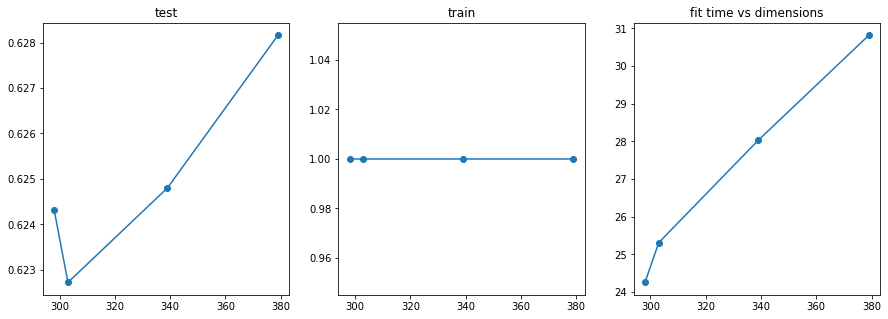

In [20]:
params, param_results= get_best_transformations(params,threshold=0.95)


In [21]:
param_results

,Dimensions,Train accuracy,Test accuracy,Train time,dilate__matrix,dilate__iterations,erode__matrix,erode__iterations
1,298,1.0,0.62432,24.258276,"(5, 5)",6,"(5, 5)",9
3,303,1.0,0.62272,25.314996,"(5, 5)",9,"(5, 5)",9
2,339,1.0,0.62480,28.030561,"(5, 5)",9,"(5, 5)",6
0,379,1.0,0.62816,30.814333,"(5, 5)",6,"(5, 5)",6


In [22]:
best_params = {
    'dilate__matrix':(5, 5),
    'dilate__iterations':9,
    'erode__matrix':(5,5),
    'erode__iterations':9
}

step 4: Adding our paramaters to a new pipeline

In [23]:
pipe = Pipeline([
    ("dilate",dilate_img(picSize=picSize)),
    ("erode",erode_img(picSize=picSize)),
    ("grayScale",grayScale(picSize=picSize)),
    ("reshape",reShape(picSize=picSize)),
    ("pca",PCA(random_state=randomSeed)),
    ("toDF", to_df())
],verbose=True)

pipe.set_params(**params)


Pipeline(steps=[('dilate', dilate_img(iterations=6, matrix=(5, 5))),
                ('erode', erode_img(iterations=9, matrix=(5, 5))),
                ('grayScale', grayScale()), ('reshape', reShape()),
                ('pca', PCA(n_components=298, random_state=36)),
                ('toDF', to_df())],
         verbose=True)

In [24]:
X_train_new = pipe.fit_transform(X_train)
X_test_new = pipe.transform(X_test)

[Pipeline] ............ (step 1 of 6) Processing dilate, total=   0.3s
[Pipeline] ............. (step 2 of 6) Processing erode, total=   0.5s
[Pipeline] ......... (step 3 of 6) Processing grayScale, total=   0.1s
[Pipeline] ........... (step 4 of 6) Processing reshape, total=   0.2s
[Pipeline] ............... (step 5 of 6) Processing pca, total=  13.2s
[Pipeline] .............. (step 6 of 6) Processing toDF, total=   0.0s


In [25]:
X_train_new.head(5)

,0,1,2,3,4,5,6,7,8,9,...,288,289,290,291,292,293,294,295,296,297
0,-2203.268884,-2297.249621,-520.996470,1086.212217,-1625.643456,315.703754,676.531053,89.870415,-51.284255,-938.657649,...,-25.073215,-50.944335,77.766523,-118.043080,-170.889848,148.635061,-67.958545,-26.853935,31.741011,26.106607
1,4473.240891,3786.487756,364.181165,320.492580,-3479.930391,831.592771,526.394093,-59.200982,1025.601441,1462.143054,...,82.903901,-2.416665,51.093015,97.815512,61.936671,57.905248,-74.938114,-68.265398,-45.217936,-29.933187
2,3402.035336,-5375.913072,241.593228,-2827.828216,1014.867790,447.761228,402.441032,355.334122,-447.123458,13.902049,...,129.249685,15.286134,-87.821291,-53.475895,-105.399350,40.295835,26.934870,-115.035540,-129.236589,52.563621
3,-2431.908531,-583.958343,-1982.709660,-187.472709,15.664001,-325.093507,-2067.368865,-3.307961,522.464206,-1736.069470,...,126.979335,-36.449087,13.191265,110.162668,-11.505800,-28.511825,-58.971272,44.144566,70.669410,13.803809
4,4457.874297,-684.533584,2626.509235,-1666.313437,1393.562259,701.608217,-1016.856278,832.898517,-568.925582,1254.438161,...,-61.671338,-48.093313,33.707168,28.000526,42.663793,-90.900422,159.910916,15.077374,85.598905,-44.251147


Image before and after transformations

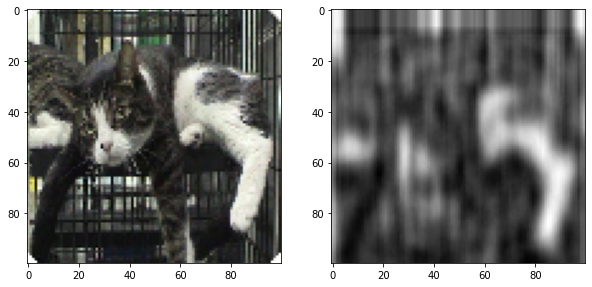

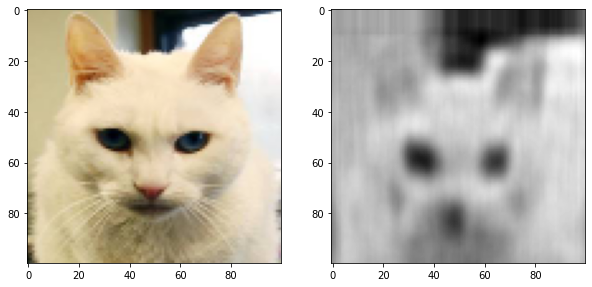

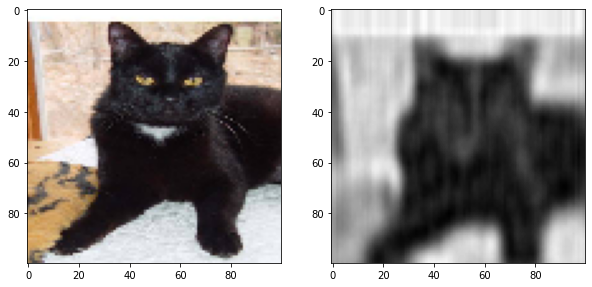

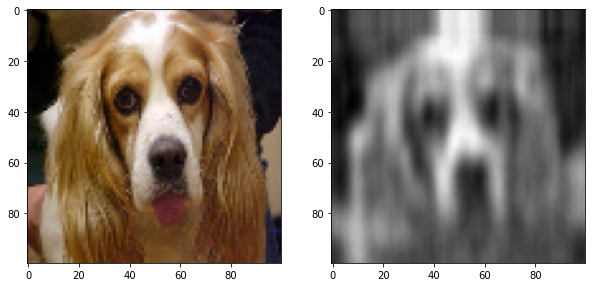

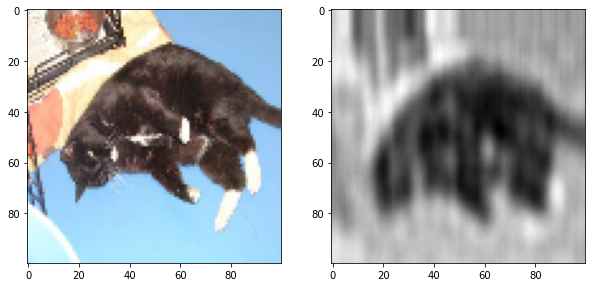

In [26]:
for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10,5)
    img = X_train[i].reshape(picSize,picSize,3)
    ax1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    pca = PCA(random_state=randomSeed,)
    img = pipe.inverse_transform(X_train_new)[i]
    
    ax2.imshow(img.reshape((picSize,picSize)),cmap="gray")
    img = None

## <u><b> Part 5 </b></u>

### Baseline model

This will act as a baseline model and we will try to improve it

In [27]:
def plot_model_results(model,X,y):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    cm = plot_confusion_matrix(model,X,y,display_labels=["cat","dog"],values_format="d",ax=ax1)
    fig.set_size_inches(20,10)
    num = cm.text_[0][0].get_text()
    txt = "True Negative"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[0][0].set_text(txt)
    
    num = cm.text_[1][0].get_text()
    txt = "False Negative"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[1][0].set_text(txt)

    num = cm.text_[0][1].get_text()
    txt = "False Positive"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[0][1].set_text(txt)

    num = cm.text_[1][1].get_text()
    txt = "True Positive"+ "\n" + num + "\n" + '{0:.3f}'.format(100*(int(num)/len(y_test)))+"%"
    cm.text_[1][1].set_text(txt)
    
    falsePosRate, truePosRate, _ = roc_curve(y,np.random.choice([0,1],size=len(y_test)))
    plot_roc_curve(model,X,y,ax=ax2)
    ax2.plot(falsePosRate, truePosRate, linestyle='--')

In [28]:
baseline = xgb.XGBClassifier(n_estimators = 200, seed=randomSeed,tree_method='hist',eval_metric="logloss")
baseline.fit(X_train_new,y_train)
baseline_prediction = baseline.predict(X_test_new)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [29]:
print("Accuracy:",accuracy_score(y_test,baseline_prediction))
print(classification_report(y_test,baseline_prediction))


Accuracy: 0.6312
              precision    recall  f1-score   support

           0       0.63      0.62      0.62      3084
           1       0.63      0.64      0.64      3166

    accuracy                           0.63      6250
   macro avg       0.63      0.63      0.63      6250
weighted avg       0.63      0.63      0.63      6250



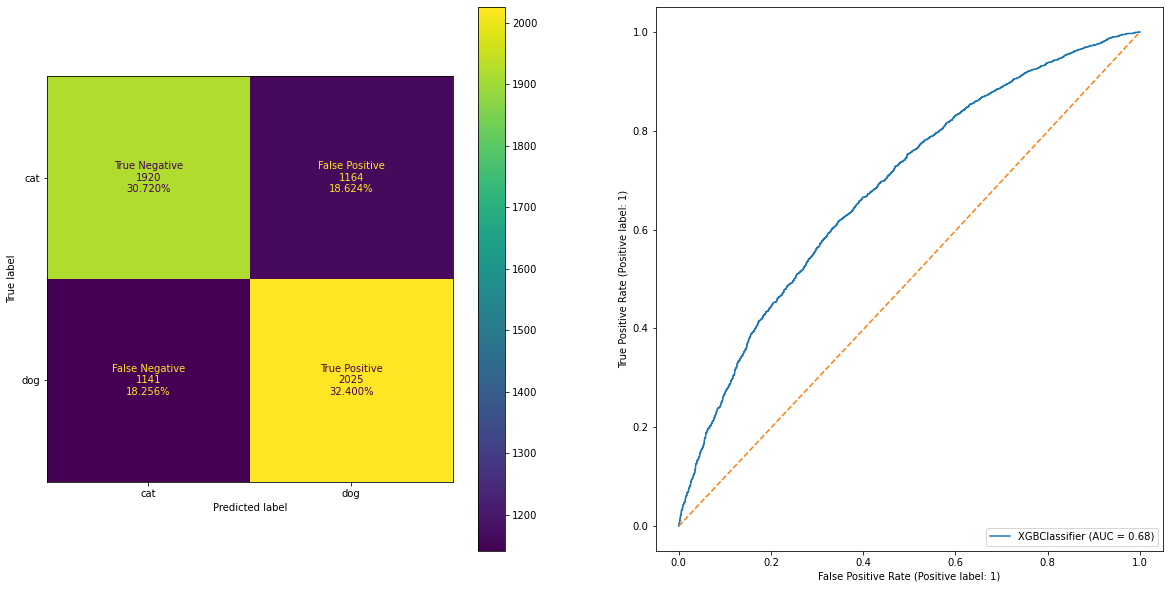

In [30]:
plot_model_results(baseline,X_test_new,y_test)

## <u><b> Part 6 </b></u>

### Paramater tuning



In [31]:
def param_search(param_grid,train,test,train_labels,test_labels,num_class=2,randomSeed=randomSeed,nfolds=5,eval_method="auc",higher_better=True,num_boost_round=10000,early_stopping_rounds=100,verbose=True):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
    done = 0
    amount = len(param_grid)
    params = {
        'random_state':randomSeed,
        'eval_metric':eval_method,
    }
    start = time.time()
    timer = time.time()
    if higher_better: 
        best_eval = -float("inf")
    else:
        best_eval = float("inf")
    best_eval_train = 0
    best_params = {}
    best_iter = 0
    best_out = ''
    with tqdm(total=len(param_grid)) as pbar:
        for p in param_grid:
            out = ''
            for key in p:
                params[key] = p[key]
                out += key + '=' + str(p[key])+', '
            out = out[:-2]
            
            results = xgb.cv(params,train,num_boost_round=num_boost_round,nfold=nfolds,metrics={eval_method},early_stopping_rounds=early_stopping_rounds,seed=randomSeed)
            
            ax1.plot(results.index,results['test-'+eval_method+'-mean'],label=out[:25])
            ax2.plot(results.index,results['train-'+eval_method+'-mean'],label=out[:25])
            ax1.set_title("validation")
            ax2.set_title("train")
            ax1.legend()
            ax2.legend()
            
            done +=1 
            #get mean score of cv of the training and testing, and get the best iteration
            if higher_better==False:
                mean_eval_test = results['test-'+eval_method+'-mean'].min()
                mean_eval_train = results['test-'+eval_method+'-mean'].min()
                iteration = results['test-'+eval_method+'-mean'].argmin()
            else: 
                mean_eval_test = results['test-'+eval_method+'-mean'].max()
                mean_eval_train = results['test-'+eval_method+'-mean'].max()
                iteration = results['test-'+eval_method+'-mean'].argmax()
            
            #update best parameters
            if (mean_eval_test < best_eval and higher_better==False) or (mean_eval_test > best_eval and higher_better):
                best_eval = mean_eval_test
                best_eval_train = mean_eval_train
                best_out = ''
                best_iter = iteration
                for key in p:
                    best_out += key + '=' + str(p[key])+', '
                    best_params[key] = p[key]
                best_out = best_out[:-2]

            #show results of cv
            if verbose:
                print("Parameters: "+out)
                print("Mean train "+eval_method+": "+str(mean_eval_train) + " Mean test "+eval_method+": "+str(mean_eval_test) + " Iteration: "+str(iteration))
                print(str(done)+"/"+str(amount))
                
                if (time.time()-timer) > 300:
                    print(str((time.time()-start)/60) +"m elapsed. Finished "+str(100*done/amount)+"%" )
                    timer = time.time()
                print("")
            pbar.update(1)
    stop = time.time()
    if verbose:
        print("----------------------------------------")
    print(f"Tuning time: {(time.time()-start)}s")
    print("Best parameters: "+best_out+":")
    print("Best mean train "+eval_method+": "+str(best_eval_train) + " Best mean test "+eval_method+": "+str(best_eval) + " Best iteration: "+str(best_iter))
    
    #show accuracy score
    bst = xgb.train(dict({'random_state':randomSeed,'eval_metric':eval_method,'num_class':num_class},**best_params), train, best_iter+1)
    test_preds = bst.predict(test)
    train_preds = bst.predict(train)

    print("Test accuracy:",accuracy_score(test_labels,test_preds),"Train accuracy:",accuracy_score(train_labels,train_preds))
    return best_params,best_iter+1

In [32]:
dtrain = xgb.DMatrix(X_train_new, label=y_train)
dtest = xgb.DMatrix(X_test_new, label=y_test)

In [33]:
params = {
    'tree_method':'hist',
    'n_jobs':-1
}

In [34]:
grid = [
    dict({'learning_rate':lr},**params) 
    for lr in [0.025,0.3]
]

  0%|          | 0/2 [00:00<?, ?it/s]

Parameters: learning_rate=0.025, tree_method=hist, n_jobs=-1
Mean train auc: 0.7028786 Mean test auc: 0.7028786 Iteration: 1368
1/2
8.223663914203645m elapsed. Finished 50.0%

Parameters: learning_rate=0.3, tree_method=hist, n_jobs=-1
Mean train auc: 0.6566105999999999 Mean test auc: 0.6566105999999999 Iteration: 134
2/2

----------------------------------------
Tuning time: 575.8963651657104s
Best parameters: learning_rate=0.025, tree_method=hist, n_jobs=-1:
Best mean train auc: 0.7028786 Best mean test auc: 0.7028786 Best iteration: 1368
Test accuracy: 0.6512 Train accuracy: 0.9968533333333334


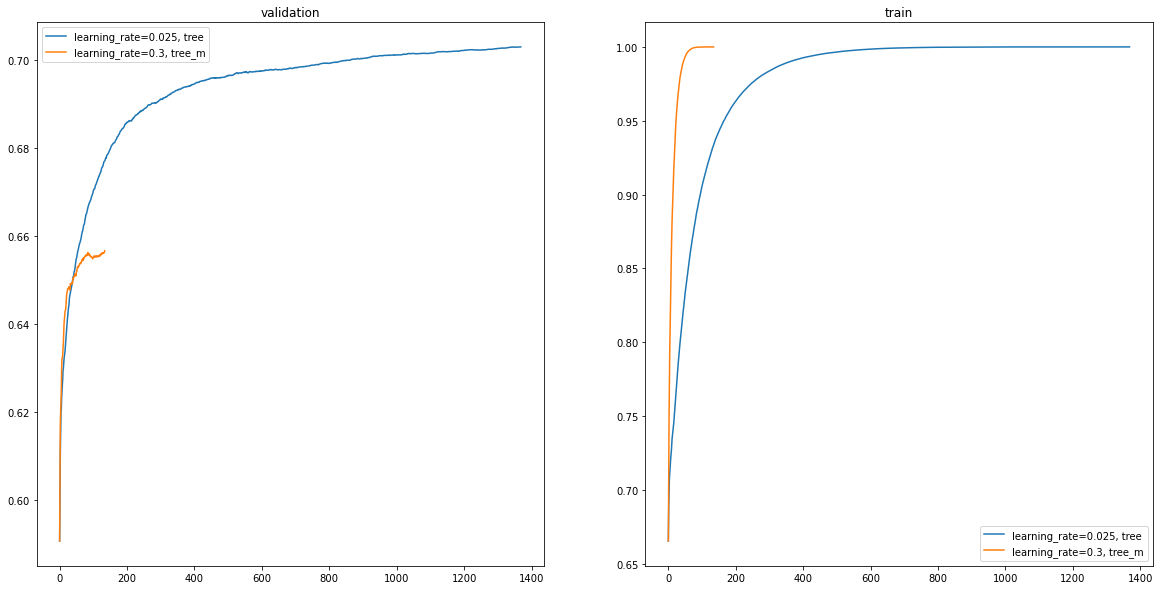

In [35]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test)

In [36]:
grid = [
    dict({'max_depth':i,'min_child_weight':j},**params)
    for i in [6]
    for j in [1,7]
]

  0%|          | 0/2 [00:00<?, ?it/s]

Parameters: max_depth=6, min_child_weight=1, learning_rate=0.025, tree_method=hist, n_jobs=-1
Mean train auc: 0.7028786 Mean test auc: 0.7028786 Iteration: 1368
1/2
8.280293385187784m elapsed. Finished 50.0%

Parameters: max_depth=6, min_child_weight=7, learning_rate=0.025, tree_method=hist, n_jobs=-1
Mean train auc: 0.7059464 Mean test auc: 0.7059464 Iteration: 1800
2/2
18.248929138978323m elapsed. Finished 100.0%

----------------------------------------
Tuning time: 1094.9372193813324s
Best parameters: max_depth=6, min_child_weight=7, learning_rate=0.025, tree_method=hist, n_jobs=-1:
Best mean train auc: 0.7059464 Best mean test auc: 0.7059464 Best iteration: 1800
Test accuracy: 0.6576 Train accuracy: 0.9990933333333334


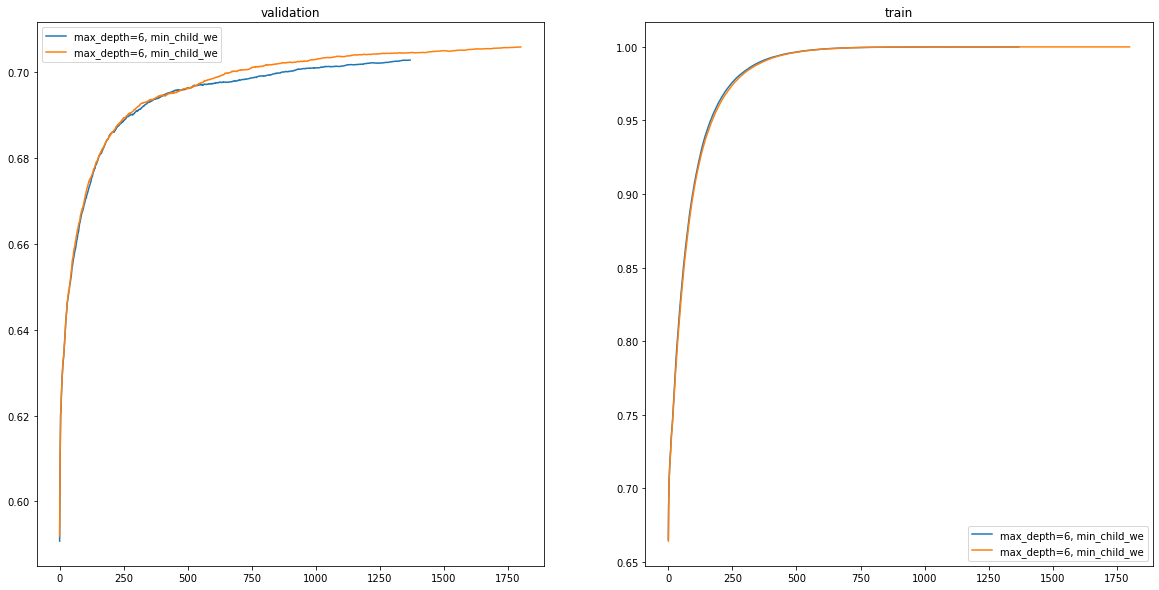

In [37]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test)

In [38]:
grid = [
    dict({'gamma':g},**params) 
    for g in [0,5]
]

  0%|          | 0/2 [00:00<?, ?it/s]

Parameters: gamma=0, max_depth=6, min_child_weight=7, learning_rate=0.025, tree_method=hist, n_jobs=-1
Mean train auc: 0.7059464 Mean test auc: 0.7059464 Iteration: 1800
1/2
9.889704954624175m elapsed. Finished 50.0%

Parameters: gamma=5, max_depth=6, min_child_weight=7, learning_rate=0.025, tree_method=hist, n_jobs=-1
Mean train auc: 0.6699751999999999 Mean test auc: 0.6699751999999999 Iteration: 145
2/2

----------------------------------------
Tuning time: 662.0863909721375s
Best parameters: gamma=0, max_depth=6, min_child_weight=7, learning_rate=0.025, tree_method=hist, n_jobs=-1:
Best mean train auc: 0.7059464 Best mean test auc: 0.7059464 Best iteration: 1800
Test accuracy: 0.6576 Train accuracy: 0.9990933333333334


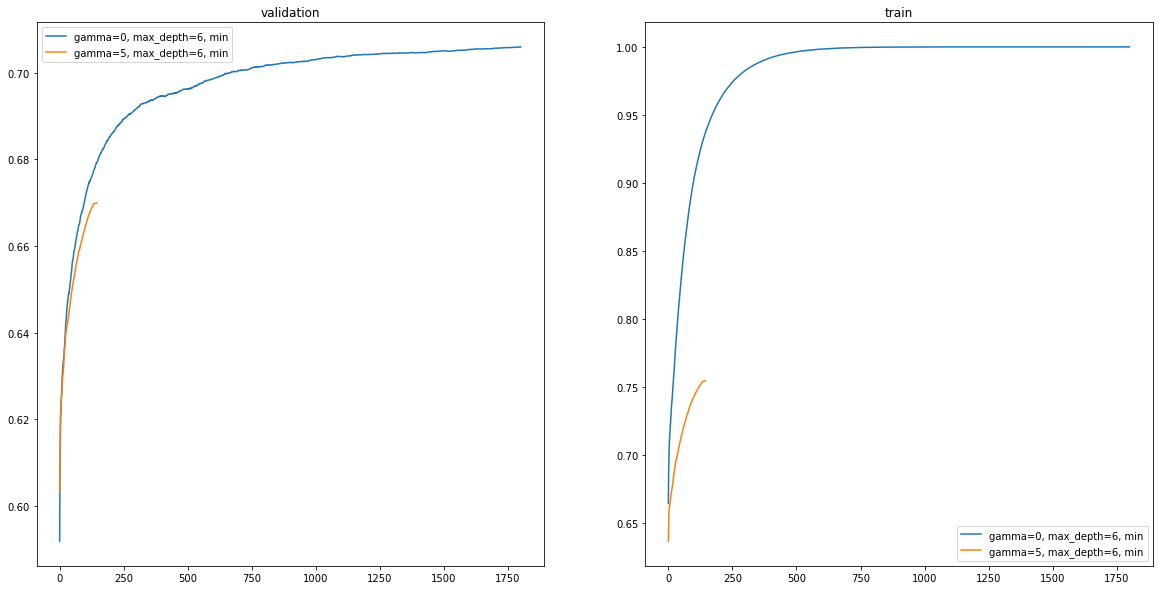

In [39]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test)

In [40]:
grid = [
    dict({'subsample':i,'colsample_bytree':j},**params) 
    for i in [0.7,1]
    for j in [0.95,1]
]

  0%|          | 0/4 [00:00<?, ?it/s]

Parameters: subsample=0.7, colsample_bytree=0.95, gamma=0, max_depth=6, min_child_weight=7, learning_rate=0.025, tree_method=hist, n_jobs=-1
Mean train auc: 0.7130162 Mean test auc: 0.7130162 Iteration: 1596
1/4
8.312942544619242m elapsed. Finished 25.0%

Parameters: subsample=0.7, colsample_bytree=1, gamma=0, max_depth=6, min_child_weight=7, learning_rate=0.025, tree_method=hist, n_jobs=-1
Mean train auc: 0.7104976 Mean test auc: 0.7104976 Iteration: 2022
2/4
19.31597218513489m elapsed. Finished 50.0%

Parameters: subsample=1, colsample_bytree=0.95, gamma=0, max_depth=6, min_child_weight=7, learning_rate=0.025, tree_method=hist, n_jobs=-1
Mean train auc: 0.7058494 Mean test auc: 0.7058494 Iteration: 2374
3/4
31.849199418226878m elapsed. Finished 75.0%

Parameters: subsample=1, colsample_bytree=1, gamma=0, max_depth=6, min_child_weight=7, learning_rate=0.025, tree_method=hist, n_jobs=-1
Mean train auc: 0.7059464 Mean test auc: 0.7059464 Iteration: 1800
4/4
41.68214257558187m elapsed. F

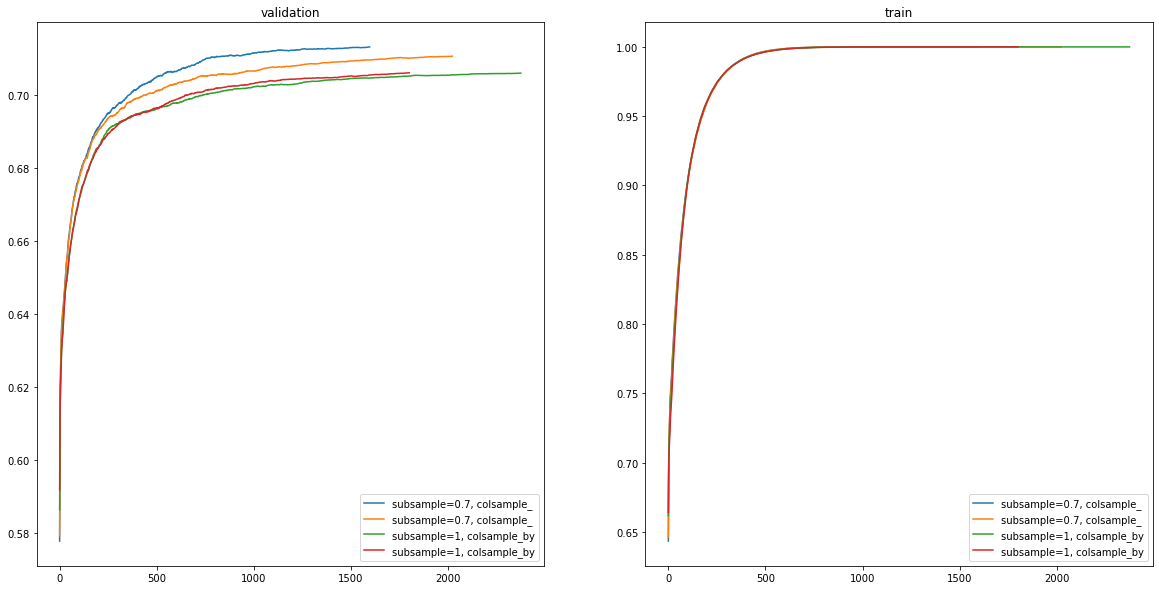

In [41]:
params,_ = param_search(grid,dtrain,dtest,y_train,y_test)

In [42]:
grid = [
    dict({'reg_lambda':i},**params) 
    for i in [1,18,20,22]
]

  0%|          | 0/4 [00:00<?, ?it/s]

Parameters: reg_lambda=1, subsample=0.7, colsample_bytree=0.95, gamma=0, max_depth=6, min_child_weight=7, learning_rate=0.025, tree_method=hist, n_jobs=-1
Mean train auc: 0.7130162 Mean test auc: 0.7130162 Iteration: 1596
1/4
8.338097004095713m elapsed. Finished 25.0%

Parameters: reg_lambda=18, subsample=0.7, colsample_bytree=0.95, gamma=0, max_depth=6, min_child_weight=7, learning_rate=0.025, tree_method=hist, n_jobs=-1
Mean train auc: 0.7137080000000001 Mean test auc: 0.7137080000000001 Iteration: 2573
2/4
21.74520914554596m elapsed. Finished 50.0%

Parameters: reg_lambda=20, subsample=0.7, colsample_bytree=0.95, gamma=0, max_depth=6, min_child_weight=7, learning_rate=0.025, tree_method=hist, n_jobs=-1
Mean train auc: 0.7148414 Mean test auc: 0.7148414 Iteration: 2685
3/4
35.72775142987569m elapsed. Finished 75.0%

Parameters: reg_lambda=22, subsample=0.7, colsample_bytree=0.95, gamma=0, max_depth=6, min_child_weight=7, learning_rate=0.025, tree_method=hist, n_jobs=-1
Mean train auc

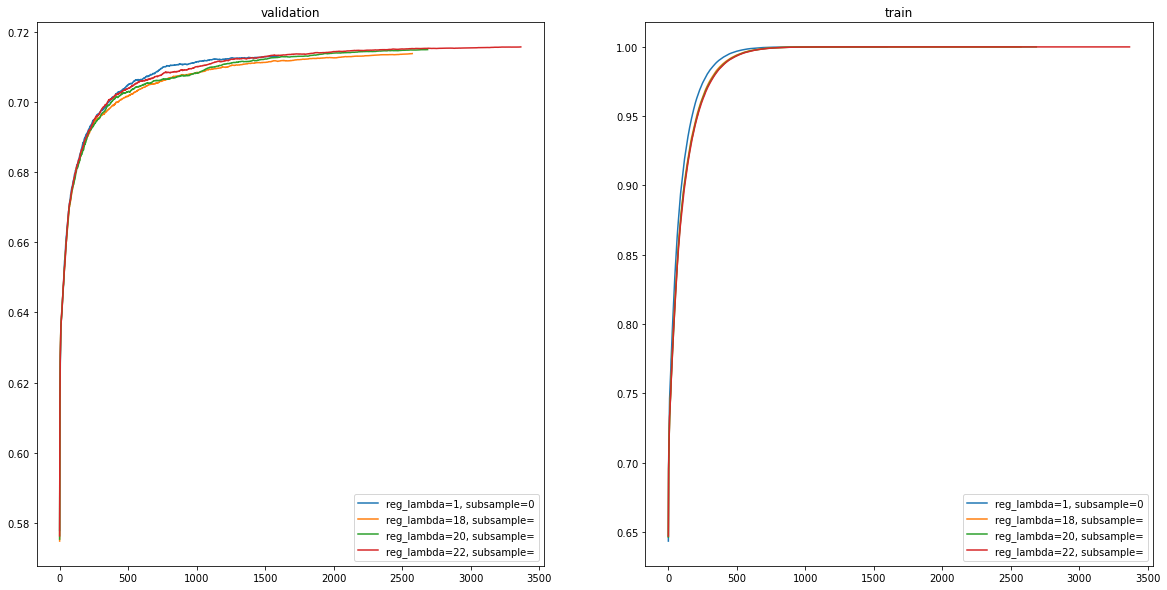

In [43]:
params,estimators = param_search(grid,dtrain,dtest,y_train,y_test)

## <u><b> Part 7 </b></u>

### Making our final model

In [44]:
xgb_model = xgb.XGBClassifier(n_estimators = estimators, random_state=randomSeed,**params,eval_metric="logloss")

In [45]:
xgb_model.fit(X_train_new,y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.95, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.025, max_delta_step=0,
              max_depth=6, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=3366, n_jobs=-1,
              num_parallel_tree=1, random_state=36, reg_alpha=0, reg_lambda=22,
              scale_pos_weight=1, subsample=0.7, tree_method='hist',
              validate_parameters=1, verbosity=None)

In [46]:
pred_xgb = xgb_model.predict(X_test_new)

In [47]:
print("Accuracy:",accuracy_score(y_test,pred_xgb))
print(classification_report(y_test,pred_xgb))

Accuracy: 0.65264
              precision    recall  f1-score   support

           0       0.65      0.64      0.65      3084
           1       0.66      0.66      0.66      3166

    accuracy                           0.65      6250
   macro avg       0.65      0.65      0.65      6250
weighted avg       0.65      0.65      0.65      6250



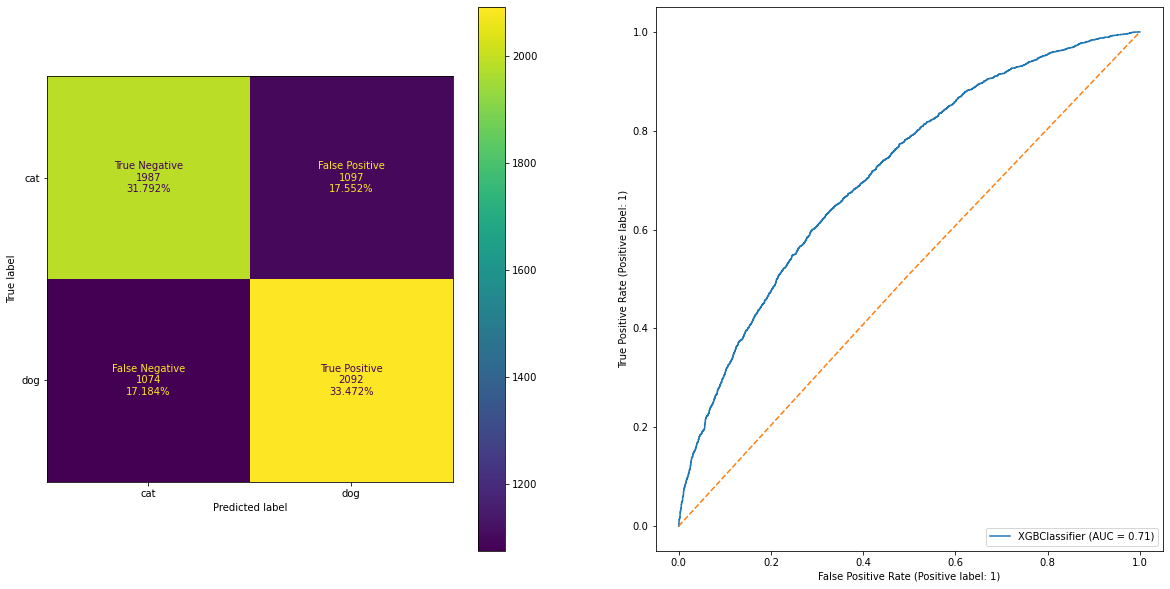

In [48]:
plot_model_results(xgb_model,X_test_new,y_test)

## <u><b> Part 8: </b></u>
### Testing model on the final data

We will now fit our model using the entire training data, and check our accuracy on the final test data

In [49]:
img_to_load = [(r"data/dogs-vs-cats/test1/",i,picSize) for i in listdir(r"data/dogs-vs-cats/test1/")]

p = Pool(processes=4)

out = p.starmap(load_img,img_to_load)

In [50]:
test_data = np.array([out[i][0] for i in range(len(out))])
out=None
test_data.shape

(12500, 100, 100, 3)

In [51]:
model = xgb.XGBClassifier(n_estimators = estimators, random_state=randomSeed,**params,eval_metric="logloss")

In [52]:
X_train = pipe.fit_transform(data)
test_data = pipe.transform(test_data)

[Pipeline] ............ (step 1 of 6) Processing dilate, total=   0.5s
[Pipeline] ............. (step 2 of 6) Processing erode, total=   0.7s
[Pipeline] ......... (step 3 of 6) Processing grayScale, total=   0.2s
[Pipeline] ........... (step 4 of 6) Processing reshape, total=   0.2s
[Pipeline] ............... (step 5 of 6) Processing pca, total=  17.1s
[Pipeline] .............. (step 6 of 6) Processing toDF, total=   0.0s


In [53]:
model.fit(X_train,target)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.95, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.025, max_delta_step=0,
              max_depth=6, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=3366, n_jobs=-1,
              num_parallel_tree=1, random_state=36, reg_alpha=0, reg_lambda=22,
              scale_pos_weight=1, subsample=0.7, tree_method='hist',
              validate_parameters=1, verbosity=None)

In [54]:
pred = model.predict(test_data)
submission = {"id":[i+1 for i in range(len(test_data))],"label":pred}
submission = pd.DataFrame(data=submission)
submission.head(10)

,id,label
0,1,0
1,2,1
2,3,1
3,4,0
4,5,0
5,6,0
6,7,1
7,8,0
8,9,1
9,10,1


In [55]:
submission.to_csv(r"data/dogs-vs-cats/sampleSubmission.csv",sep='\t')

In [56]:
end_time = time.time()
e = end_time-start_time


In [57]:
print('{:0.0f}:{:0.0f}:{:0.0f}'.format(e // 3600, (e % 3600 // 60), e % 60))

3:3:3
